In [1]:
import re
from functools import reduce
from collections import Counter
from tqdm import tqdm

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import OrdinalEncoder

from datasets.fbp_dataset import FBPDataset
from datasets.fbp_dataset import load_texts
from datasets.processing_funcs import PIPELINE

nltk.download("stopwords")
plt.style.use('ggplot')
def color_map(idx: int) -> str:
    return list(rcParams['axes.prop_cycle'])[idx]['color']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zumo0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
documents, tags = load_texts("./input/feedback-prize-2021/", PIPELINE, 1)
encoder = OrdinalEncoder()
label_unique = np.array(tags["discourse_type"].unique())
encoder.fit(label_unique.reshape(-1, 1))
dataset = FBPDataset(documents, tags, encoder, True)


Loading Dataset: 100%|██████████| 15594/15594 [00:59<00:00, 263.74it/s]


In [5]:
tags.sample(3)


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,box_center,box_length
15418,83A7376E9454,1618768793603,792,1456,"For example, If Generic_Name tells Generic_Nam...",Evidence,Evidence 2,130 131 132 133 134 135 136 137 138 139 140 14...,0.293011,0.192204
140199,964AC0FD4F70,1617991720603,2147,2716,Not knowing the situation personally might cha...,Evidence,Evidence 3,380 381 382 383 384 385 386 387 388 389 390 39...,0.753521,0.175274
69685,6903F409E831,1616604772857,1204,1330,Activating this new policy would force any stu...,Claim,Claim 2,209 210 211 212 213 214 215 216 217 218 219 22...,0.623724,0.061224


# General

In [6]:
doc_len = documents.map(lambda x: len(x.split()))

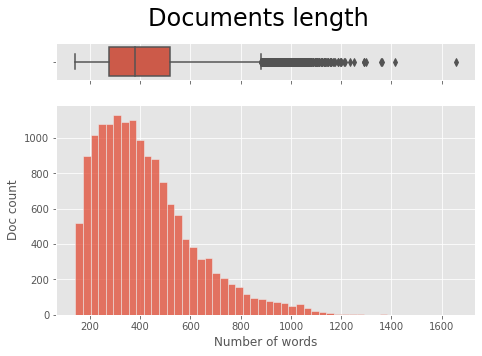

In [7]:
fig, (ax_box, ax_hist) = plt.subplots(
    2, figsize=(7.5, 5), sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
) # type: ignore
# assigning a graph to each ax
sns.boxplot(x=doc_len, color=color_map(0), ax=ax_box)
sns.histplot(x=doc_len, color=color_map(0), bins=50, ax=ax_hist)
 
fig.suptitle("Documents length", fontsize=24)
ax_box.set_xlabel("")
ax_hist.set_xlabel("Number of words")
ax_hist.set_ylabel("Doc count")
plt.savefig("figures/documents_length_his.pdf")
plt.show()


# Classes

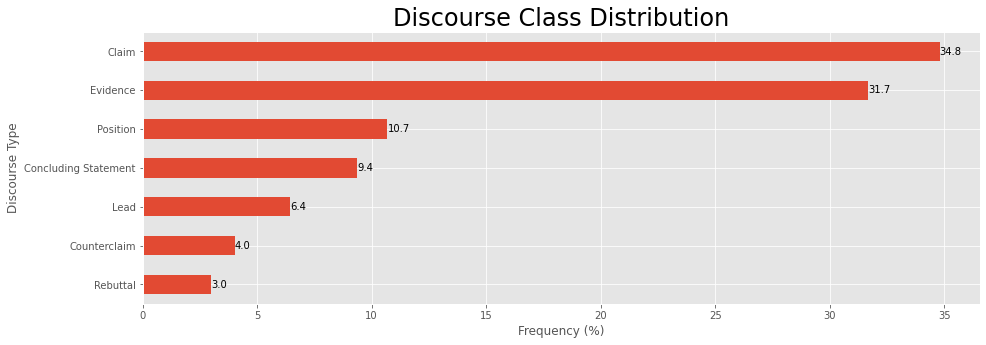

In [8]:
gp = tags.groupby(by="discourse_type")[["id"]].count()
gp = (gp / gp.sum()) * 100
ax = (
    gp
    .sort_values("id")
    .plot(
        kind="barh",
        figsize=(15, 5),
        xlabel="Discourse Type",
        legend=False,
    )
)
assert isinstance(ax, plt.Axes)
ax.set_title("Discourse Class Distribution", fontsize=24)
ax.set_xlabel("Frequency (%)")
ax.bar_label(ax.containers[0], label_type="edge", fmt="%.1f")
plt.savefig("figures/class_freqs.pdf")
plt.show()


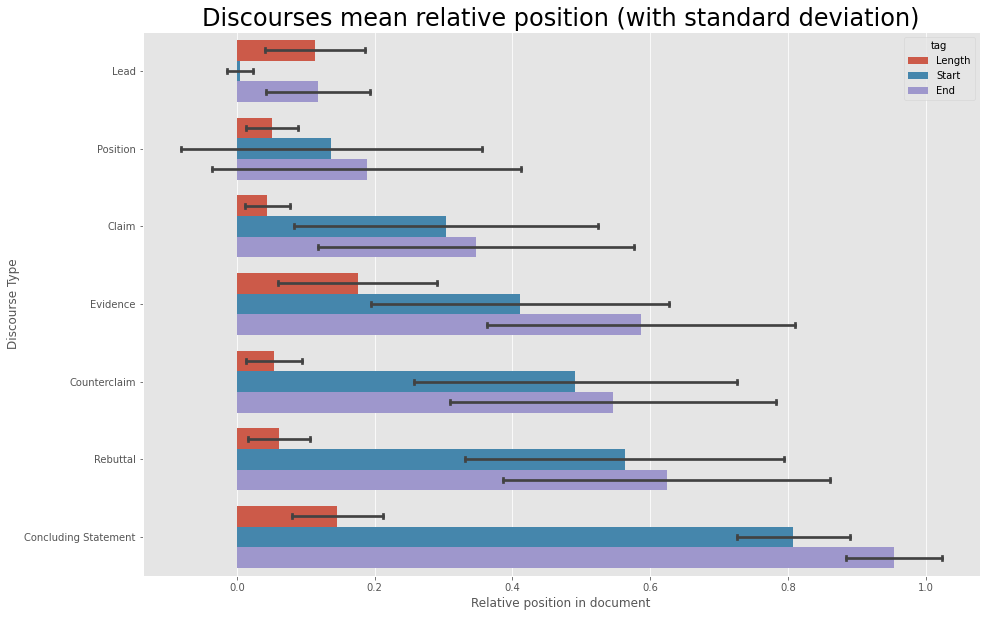

In [9]:
# Realive positions
tmp = tags[["discourse_type"]].copy()
tmp["discourse_len"] = tags["box_length"]
tmp["discourse_start"] = tags["box_center"] - tags["box_length"] / 2
tmp["discourse_end"] = tags["box_center"] + tags["box_length"] / 2

tmp_end = tmp[["discourse_type", "discourse_end"]].copy()
tmp_end.columns = ["discourse_type", "position"]
tmp_end["tag"] = "End"

tmp_start = tmp[["discourse_type", "discourse_start"]].copy()
tmp_start.columns = ["discourse_type", "position"]
tmp_start["tag"] = "Start"

tmp_len = tmp[["discourse_type", "discourse_len"]].copy()
tmp_len.columns = ["discourse_type", "position"]
tmp_len["tag"] = "Length"

tmp_cat = pd.concat([tmp_len, tmp_start, tmp_end])

plot_order = (
    tmp.groupby("discourse_type")["discourse_start"].mean().sort_values().index.values
)

plt.figure(figsize=(15, 10))
sns.barplot(
    x="position",
    y="discourse_type",
    hue="tag",
    data=tmp_cat,
    ci="sd",  # type: ignore
    capsize=0.05,
    order=plot_order,
)

plt.title("Discourses mean relative position (with standard deviation)", fontsize=24)
plt.ylabel("Discourse Type")
plt.xlabel("Relative position in document")
plt.savefig("figures/discourse_rel_pos.pdf")
plt.show()

# Number of queries

In [10]:
grouped = tags.groupby(by="id")

arg_seg = np.zeros(len(grouped))
non_arg = np.zeros(len(grouped))
for j, (k, gp) in enumerate(grouped):
    arg_seg[j] = len(gp)
    for i in range(len(gp) - 1):
        pred_str1 = gp["predictionstring"].iloc[i].split()
        pred_str2 = gp["predictionstring"].iloc[i + 1].split()
        start = int(pred_str1[-1])
        end = int(pred_str2[0])
        if start + 1 != end:
            non_arg[j] += 1

seg = non_arg + arg_seg

print(f"The maximum number of units for document is : {int(np.max(seg))}")
print(f"The maximum number of argumentative units for document is : {int(np.max(arg_seg))}")


The maximum number of units for document is : 32
The maximum number of argumentative units for document is : 26


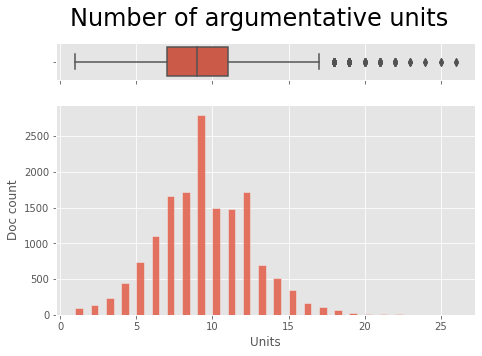

In [11]:
fig, (ax_box, ax_hist) = plt.subplots(
    2, figsize=(7.5, 5), sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
) # type: ignore
# assigning a graph to each ax
sns.boxplot(x=arg_seg, color=color_map(0), ax=ax_box)
sns.histplot(x=arg_seg, color=color_map(0), bins=50, ax=ax_hist) # type: ignore
 
fig.suptitle("Number of argumentative units", fontsize=24)
ax_box.set_xlabel("")
ax_hist.set_xlabel("Units")
ax_hist.set_ylabel("Doc count")
plt.savefig("figures/arg_units_per_doc_hist.pdf")
plt.show()


# Class Correlation

In [12]:
REPLACE_BY_SPACE_RE = re.compile("[.,;!?']")
STOPWORDS = set(nltk.corpus.stopwords.words("english"))


def remove_stopwords(text: str) -> str:
    return " ".join([x for x in text.split() if x and x not in STOPWORDS])


def replace_special_characters(text: str) -> str:
    return REPLACE_BY_SPACE_RE.sub(" ", text)


NEW_PIPELINE = PIPELINE + [replace_special_characters, remove_stopwords]


def get_words(gp) -> "list[str]":
    group = gp["discourse_text"]
    words = []
    for i in range(len(group)):
        words += reduce(lambda txt, f: f(txt), NEW_PIPELINE, group.iloc[i]).split()
    return words

In [13]:
counted = {key: Counter(get_words(gp)) for key, gp in tags.groupby(by="discourse_type")}

labels = list(counted.keys())
word_list = list(set().union(*[set(counts.keys()) for counts in counted.values()]))

tot_word_class = np.array([sum(c for c in counted[k].values()) for k in labels])

discurse_occ = Counter()
num_discourses = 0
for _, dis in tags.groupby(by="discourse_id"):
    num_discourses += 1
    for word in set(get_words(dis)):
        discurse_occ[word] += 1

def correlation(word: str) -> np.ndarray:
    """Term Frequency in each class * inverse discourse frequency"""
    num_word_class = np.array([counted[key].get(word, 0) for key in labels])
    tf = num_word_class / tot_word_class
    idf = np.log10(len(dataset) /(1 + discurse_occ[word]))
    return tf * idf

matrix = np.zeros((len(word_list), len(labels)))
for i, w in enumerate(word_list):
    matrix[i, :] = correlation(w)

weights = pd.DataFrame(matrix, columns=labels, index=word_list)

summary = (
    weights.copy()
    .assign(order=weights.max(axis=1))
    .sort_values("order", ascending=False)
    .drop("order", axis=1)
    .loc[(weights == weights.max()).any(axis=1)]
)

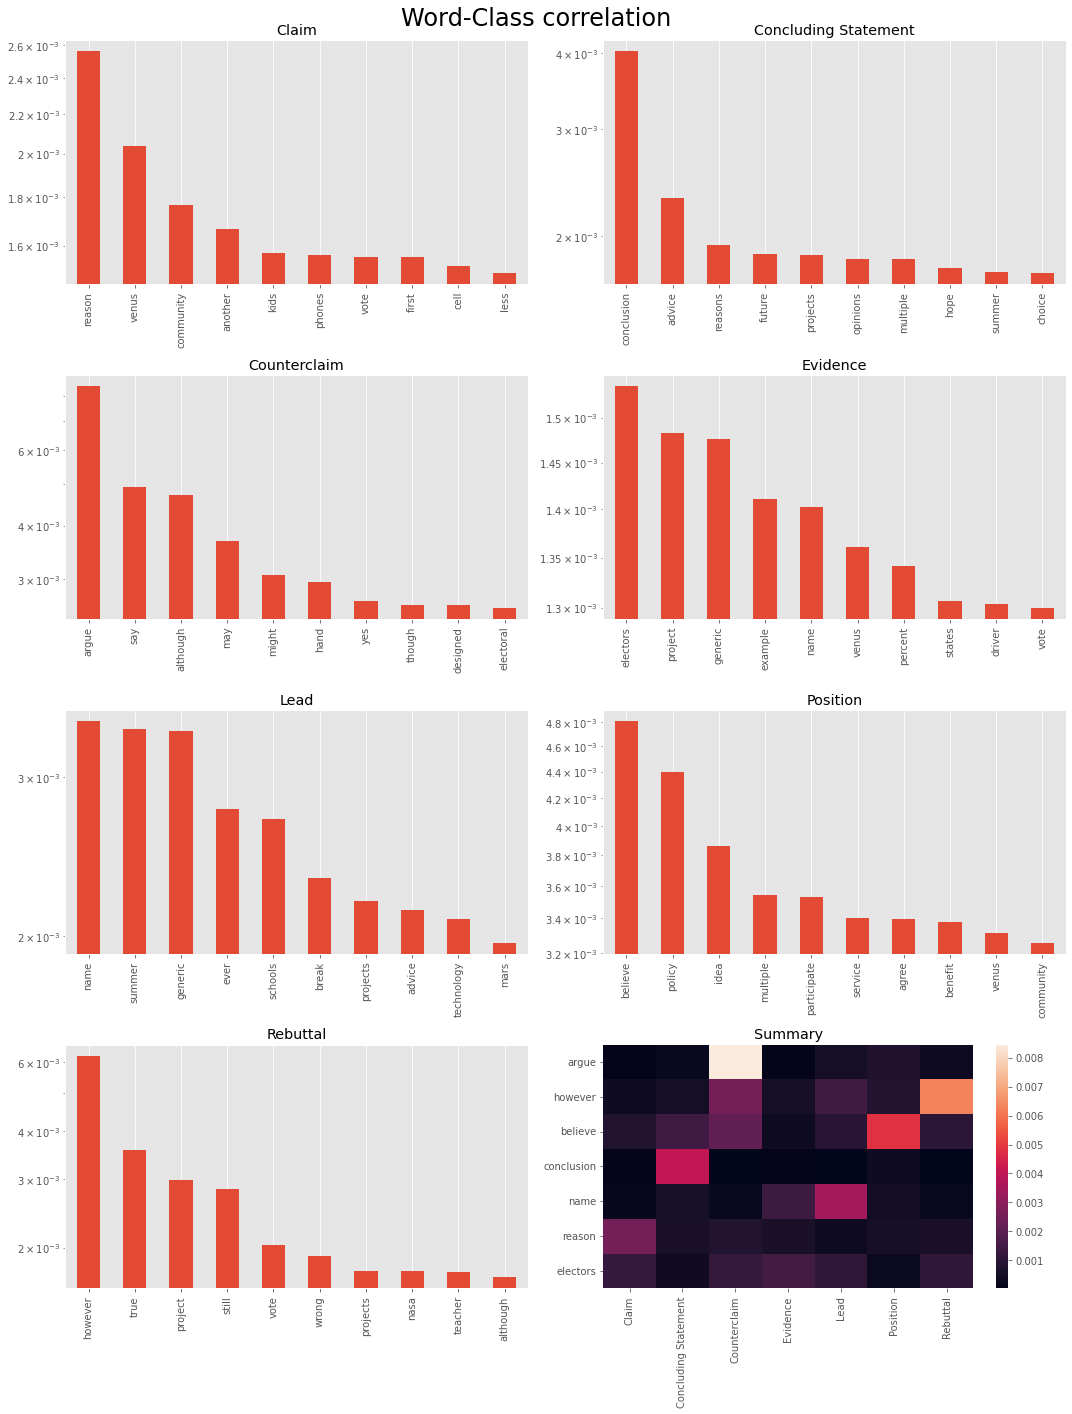

In [14]:
axs: "tuple[tuple[plt.Axes, ...], ...]"
fig, axs = plt.subplots(4, 2, figsize=(15, 20)) # type: ignore

for i, col in enumerate(weights.columns):
    ax = axs[i//2][i%2]
    df = weights[[col]].sort_values(by=[col], ascending=False)
    df = df[col].head(10).plot(kind="bar", title=col, ax=ax)
    ax.set_yscale("log")

sns.heatmap(summary, ax=axs[3][1])
axs[3][1].set_title("Summary")
fig.suptitle("Word-Class correlation", fontsize=24)
fig.tight_layout()
plt.savefig("figures/word_class_correlation.pdf")
plt.show()

# End